In [18]:
import numpy as np
import serial, time
import math
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [19]:
l1=20.2 #milimetros
l2=16.0
l3=19.5
l4=6.715
A01 = lambda q1: np.array([ [np.cos(q1),    0, np.sin(q1),     0],
                            [np.sin(q1),    0, -np.cos(q1),    0],
                            [     0,        1,       0,       l1],
                            [     0,        0,       0,        1]])
A12 = lambda q2: np.array([ [-np.sin(q2), -np.cos(q2),   0,  -l2*np.sin(q2)],
                            [np.cos(q2), -np.sin(q2),    0,  l2*np.cos(q2)],
                            [       0,                  0,              1,                      0],
                            [       0,                  0,              0,                      1]])
A23 = lambda q3: np.array([ [np.sin(q3), 0, np.cos(q3),    0],
                            [-np.cos(q3), 0,  np.sin(q3),    0],
                            [     0,            -1,       0,  0],
                            [     0,             0,       0,  1]])
A34 = lambda q4: np.array([ [np.cos(q4),    0,  np.sin(q4), 0],
                            [np.sin(q4),    0, -np.cos(q4), 0],
                            [     0,        1,       0,    l3],
                            [     0,        0,       0,     1]])
A45 = lambda q5: np.array([ [np.cos(q5),    0,  -np.sin(q5), 0],
                            [np.sin(q5),    0, np.cos(q5), 0],
                            [     0,                -1,          0,          0],
                            [     0,                0,          0,          1]])
A56 = lambda q6: np.array([ [np.cos(q6), -np.sin(q6), 0,        0],
                            [np.sin(q6),  np.cos(q6), 0,        0],
                            [     0,         0,       1,       l4],
                            [     0,         0,       0,        1]])
T = lambda phi,theta,thi: np.array([[np.cos(phi)*np.cos(theta), np.cos(phi)*np.sin(theta)*np.sin(thi)-np.sin(phi)*np.sin(thi), np.cos(phi)*np.sin(theta)*np.cos(thi)+np.sin(phi)*np.sin(thi), 0],
                                    [np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta)*np.sin(thi)+np.cos(phi)*np.cos(thi), np.sin(phi)*np.sin(theta)*np.cos(thi)-np.cos(phi)*np.sin(thi), 0],
                                    [       -np.sin(theta),                 np.cos(theta)*np.sin(thi),                              np.cos(theta)*np.cos(thi),                                0],
                                    [             0,                                     0,                                                      0,                                           1]])


Cinematica Directa

In [20]:
def direct_kinematics(q1,q2,q3,q4,q5,q6):
    _0A2 = np.dot(A01(q1),A12(q2))
    _0A3 = np.dot(_0A2,A23(q3))
    _0A4 = np.dot(_0A3,A34(q4))
    _0A5 = np.dot(_0A4,A45(q5))
    _0A6 = np.dot(_0A5,A56(q6))
    return _0A6 

Cinemativa Inversa

In [21]:
def inverse_kinematics_P1(x, y, z, a, b, g):
    signoQ3=-1
    codo = 1
    
    #Calculo del vector de orientacion del eje de la herramienta con respecto al eje de la base Angulos de Euler
    alpha=a*np.pi/180.0
    beta=b*np.pi/180.0
    gamma=g*np.pi/180.0
    Transform = T(alpha, beta, gamma) #Matriz de tranformacion directa
    
    n = Transform[0,0:3]
    o = Transform[1,0:3]
    a = Transform[2,0:3]

    #Calculo de punto muñeca
    pmx = x - l4*a[0]
    pmy = y - l4*a[1]
    pmz = z - l4*a[2] - l1
        
    print("Punto Muñeca Calculado: ")       
    print(pmx,pmy,pmz) #debug
    
    # Halla q1
    q1 = np.arctan2(pmy,pmx)
    if q1 > np.pi or q1 < -np.pi:
        print("fuera del rango")
        return None
    
    #q3
    cosq3=(pmx**2+pmy**2+pmz**2-l2**2-l3**2)/(2*l2*l3)
    sinq3=(signoQ3)*np.sqrt(1-cosq3**2)
    q3=np.arctan2(sinq3,cosq3)
    if q3 > np.pi/1.9 or q3 < -np.pi/1.9:
        signoQ3*=-1
        sinq3=(signoQ3)*np.sqrt(1-cosq3**2)
        q3=np.arctan2(sinq3,cosq3)
        if q3 > np.pi/1.9 or q3 < -np.pi/1.9:
            print("fuera del rango")
            return None
    #print(q3)
    
    #q2
    q2=(np.arctan2(pmz,(codo*np.sqrt(pmx**2+pmy**2))) - np.arctan2((l3*sinq3),(l2+l3*cosq3)))-np.pi/2
    if q2 > np.pi/1.9 or q2 < -np.pi/1.9:
        codo*=-1
        q2=(np.arctan2(pmz,(codo*np.sqrt(pmx**2+pmy**2))) - np.arctan2((l3*sinq3),(l2+l3*cosq3)))-np.pi/2
        if q2 > np.pi/1.9 or q2 < -np.pi/1.9:
            print("fuera del rango")
            return None
    #print(q2)
    
    cosq1=np.cos(q1)
    cosq2=np.cos(q2)
    sinq1=np.sin(q1)
    sinq2=np.sin(q2) 

    """ q5=np.arccos(-a[0]*cosq1*(cosq2*sinq3+cosq3*sinq2)-a[1]*sinq1*(cosq2*sinq3+cosq3*sinq2)+a[2]*(cosq2*cosq3-sinq2*sinq3))
    if q5 > np.pi/2 or q5 < -np.pi/2:
        print("Q5 fuera del rango")
        return None
    sinq5=np.sin(q5)

    q4=np.arctan2((cosq1*a[1]-sinq1*a[0]),abs(a[2]*(cosq2*sinq3+cosq3*sinq2)+(cosq2*cosq3-sinq2*sinq3)*(a[1]*sinq1+a[0]*cosq1)))

    sinq4=np.sin(q4)
    cosq4=np.cos(q4)

    q6=np.arcsin(n[0]*(-2*cosq4*sinq1+cosq1*sinq4*(-cosq2*cosq3+sinq2*sinq3))+n[1]*(cosq1*cosq4+sinq1*sinq4*(sinq2*sinq3-cosq2*cosq3))-n[2]*sinq4*(cosq2*sinq3+cosq3*sinq2))
     """
     
    A03 = np.dot(A01(q1),A12(q2))# los angulos aca deben estar en radianes
    A03 = np.dot(A03,A23(q3))
    #print(A03)#debug
    R03_inv = A03[0:3,0:3].T
    #print(R03_inv)#debug
    R36 = np.dot(R03_inv,Transform[0:3,0:3].T) 
    
    q5 = -np.arccos(R36[2,2]) 
    q4 = np.arccos(R36[1,2]/np.sin(q5))
    q6 = -np.arcsin(R36[2,1]/np.sin(q5))
     
    q1 = np.degrees(q1).round(decimals=3)
    q2 = np.degrees(q2).round(decimals=3)
    q3 = np.degrees(q3).round(decimals=3)
    q4 = np.degrees(q4).round(decimals=3)
    q5 = np.degrees(q5).round(decimals=3)
    q6 = np.degrees(q6).round(decimals=3)
    print("q1: ", str(q1))
    print("q2: ", str(q2))
    print("q3: ", str(q3))
    print("q4: ", str(q4))
    print("q5: ", str(q5))
    print("q6: ", str(q6))

    return q1, q2, q3, q4, q5, q6


In [216]:
def inverse_kinematics_G1(x, y, z):
    signoQ3=-1
    codo = 1

    #Calculo de punto muñeca
    pmx = x
    pmy = y
    pmz = z -l1
        
    print("Punto Muñeca Calculado: ")       
    print(pmx,pmy,pmz) #debug
    
    # Halla q1
    q1 = np.arctan2(pmy,pmx)
    if q1 > np.pi or q1 < -np.pi:
        print("Q1 fuera del rango")
        return None
    
    #q3
    
    cosq3=(pmx**2+pmy**2+pmz**2-l2**2-l3**2)/(2*l2*l3)
    if cosq3 < -1:
        cosq3 = int(cosq3)
    if cosq3 > 1:
        print("Fuera del espacion de Trabajo",str(cosq3))
        return None
    print("cosq3: ",str(cosq3))
    sinq3=(signoQ3)*np.sqrt(1-cosq3**2)
    q3=np.arctan2(sinq3,cosq3)
    if q3 > np.pi/2.1 or q3 < -np.pi/2.1:
        signoQ3*=-1
        print("q3: -", str(q3))
        sinq3=(signoQ3)*np.sqrt(1-cosq3**2)
        q3=np.arctan2(sinq3,cosq3)
        if q3 > np.pi/2.1 or q3 < -np.pi/2.1:
            print("Q3 fuera del rango")
            return None
    print("q3: ", str(q3))
    
    #q2
    aa = np.arctan2(pmz,np.sqrt(pmx**2+pmy**2))
    u = np.sqrt(pmx**2 + pmy**2 + pmz**2)
    q22 = np.pi/2 - (np.arccos((l2**2+u**2-l3**2)/(2*l2*u))+aa)
    q33 = np.pi - np.arccos((l2**2 + l3**2 - u**2) / (2 * l2 * l3))
    print("q2,q3")
    print(np.degrees(q22).round(decimals = 3),np.degrees(q33).round(decimals = 3))
    
    q2=(np.arctan2(pmz,(codo*np.sqrt(pmx**2+pmy**2))) - np.arctan2((l3*sinq3),(l2+l3*cosq3)))-np.pi/2
    if q2 > np.pi/2.1 or q2 < -np.pi/2.1:
        codo*=-1
        q2=(np.arctan2(pmz,(codo*np.sqrt(pmx**2+pmy**2))) - np.arctan2((l3*sinq3),(l2+l3*cosq3)))-np.pi/2
        if q2 > np.pi/2.1 or q2 < -np.pi/2.1:
            print("Q2 fuera del rango")
            return None
    #print(q2)
    
    q1 = np.degrees(q1).round(decimals=3)
    q2 = np.degrees(q2).round(decimals=3)
    q3 = np.degrees(q3).round(decimals=3)
    print("q1: ", str(q1))
    print("q2: ", str(q2))
    print("q3: ", str(q3))

    return q1, q2, q3


Funcion para interpolacion

In [219]:

def Interpolacion_WorkSpace(points):
    print(points)
    # Extraer los puntos individuales
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]

    # Crear una secuencia de valores t para los puntos originales
    t_points = np.linspace(0, 1, len(points))

    # Crear una secuencia de valores t para la interpolación (30 puntos)
    t_interpolated = np.linspace(0, 1, 30)

    # Realizar la interpolación cúbica
    cs_x = CubicSpline(t_points, x_points)
    cs_y = CubicSpline(t_points, y_points)
    cs_z = CubicSpline(t_points, z_points)

    # Generar los puntos interpolados
    x_interpolated = cs_x(t_interpolated)
    y_interpolated = cs_y(t_interpolated)
    z_interpolated = cs_z(t_interpolated)

    # Guardar los puntos interpolados en una matriz
    interpolated_points = np.vstack((x_interpolated, y_interpolated, z_interpolated)).T

    print("Puntos de la interpolacion:")
    print(interpolated_points)
    
    # Visualizar la trayectoria original e interpolada
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_points, y_points, z_points, '*', label='Puntos originales')
    ax.plot(x_interpolated, y_interpolated, z_interpolated, 'o', label='Puntos Interpolados')
    ax.plot(x_interpolated, y_interpolated, z_interpolated, '-', label='Trayectoria interpolada')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Trayectoria Interpolada del Brazo Robótico Thor')
    ax.legend()
    plt.show()

    #return interpolated_points

points = np.array([
    [15, 15,  35],        # Punto 1
    [21.7,  13.2,  37.7],  # Punto 2
    [23.9, 12.9, 43.5],  # Punto 4
    [ 10.2, 14.5, 44.2],  # Punto 3
    [-8,  16.5,  45.9],   # Punto 5 ##Leer
    [-12.4,  15.7,  45.7]
])

Puntos de la interpolacion:
[[ 15.          15.          35.        ]
 [ 15.3289893   14.90168032  35.07658906]
 [ 16.20777251  14.64406457  35.30941669]
 [ 17.47407255  14.2831677   35.70307355]
 [ 18.96561239  13.87500463  36.2621503 ]
 [ 20.52011496  13.47559032  36.99123762]
 [ 21.97543474  13.14085005  37.89480737]
 [ 23.19731275  12.90770637  38.9521483 ]
 [ 24.11370851  12.77068415  40.08636227]
 [ 24.66100011  12.71857157  41.21294868]
 [ 24.77556564  12.74015682  42.24740691]
 [ 24.3937832   12.82422808  43.10523638]
 [ 23.45341562  12.9597052   43.70370447]
 [ 21.94605722  13.14062703  44.02880936]
 [ 19.93323131  13.36768209  44.15583296]
 [ 17.4811347   13.64200335  44.16602414]
 [ 14.65596419  13.96472374  44.14063178]
 [ 11.52391656  14.33697624  44.16090476]
 [  8.15418403  14.75843288  44.30326224]
 [  4.66077899  15.2069065   44.57185624]
 [  1.19221651  15.64338259  44.91520746]
 [ -2.10210082  16.0284138   45.28040553]
 [ -5.07277039  16.3225528   45.61454011]
 [ -7.

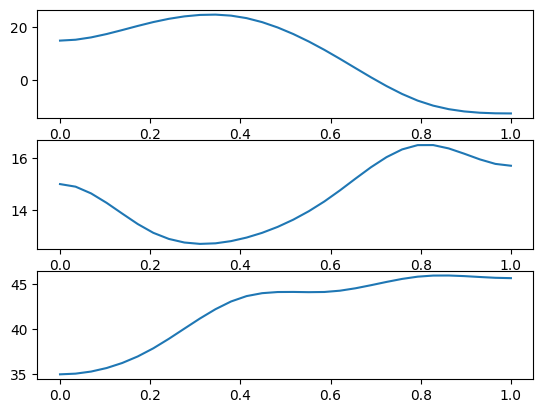

In [225]:
def interpolacion_QsSpace(points):
    # Extraer los puntos individuales
    q1_points = points[:, 0]
    q2_points = points[:, 1]
    q3_points = points[:, 2]

    # Crear una secuencia de valores t para los puntos originales
    t_points = np.linspace(0, 1, len(points))

    # Crear una secuencia de valores t para la interpolación (30 puntos)
    t_interpolated = np.linspace(0, 1, 30)

    # Realizar la interpolación cúbica
    cs_x = CubicSpline(t_points, q1_points,bc_type = 'clamped')
    cs_y = CubicSpline(t_points, q2_points,bc_type = 'clamped')
    cs_z = CubicSpline(t_points, q3_points,bc_type = 'clamped')

    # Generar los puntos interpolados
    q1_interpolated = cs_x(t_interpolated)
    q2_interpolated = cs_y(t_interpolated)
    q3_interpolated = cs_z(t_interpolated)

    # Guardar los puntos interpolados en una matriz
    interpolated_points = np.vstack((q1_interpolated, q2_interpolated, q3_interpolated)).T

    print("Puntos de la interpolacion:")
    print(interpolated_points)

    # Visualizar la trayectoria original e interpolada
    fig = plt.figure()
    ax = fig.add_subplot(311)
    ax.plot( t_interpolated,q1_interpolated, '-', label='Puntos originales')
    ax = fig.add_subplot(312)
    ax.plot( t_interpolated,q2_interpolated, '-', label='Puntos originales')
    ax = fig.add_subplot(313)
    ax.plot( t_interpolated,q3_interpolated, '-', label='Puntos originales')
    plt.show()
points = np.array([
    [15, 15,  35],        # Punto 1
    [21.7,  13.2,  37.7],  # Punto 2
    [23.9, 12.9, 43.5],  # Punto 4
    [ 10.2, 14.5, 44.2],  # Punto 3
    [-8,  16.5,  45.9],   # Punto 5 ##Leer
    [-12.4,  15.7,  45.7]
])
interpolacion_QsSpace(points)


Conversor de Cartesiano a polar

In [24]:
def cartesian2polar(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    Q = np.arctan2(y,x)
    phi = np.arccos(z/r) 
    return r,Q,phi

In [25]:
def polar2cartesian(r,q,phi):
    x = r*np.sin(phi)*np.cos(q)
    y = r*np.sin(phi)*np.sin(q)
    z = r*np.cos(phi)
    return x, y, z

Programa Principal
26.215 0 36.2 0 -90 0
-26.215 0 36.2 0 90 0 

In [26]:
msg = input("[Escriba el comando] => ")
msg = msg.strip()
msg = msg.split()
print(msg)
for k in range(1,len(msg)-1):
    msg[k] = float(msg[k])
funcion = msg[0]
type = msg[-1]

if funcion == "P1":
    pr = msg[1:4]
    orient = msg[4:7]
    q1, q2, q3, q4, q5, q6 = inverse_kinematics_P1(pr[0], pr[1], pr[2], orient[0], orient[1], orient[2])
if funcion == "G1":
    pr = msg[1:4]
    print(pr)
    q1, q2, q3 = inverse_kinematics_G1(pr[0], pr[1], pr[2])
if funcion == "G2":
    print(msg)


[]


IndexError: list index out of range

Limites 
En el eje Z esta limitado a partir de
Z >= 46.4 para X=Y=0


In [228]:
vec = inverse_kinematics_G1(15, 15, 35)#23.953
vec 
#G1 16.38 19.53 23.95 1
#G1 12 15 45.2
#G1 13 -15 404
#G1 -15 12 45
#G1 13 16 46
#G1 20 20 46.4 1
#P1 26.215 0 36.2 0 -90 0 1

Punto Muñeca Calculado: 
15 15 14.8
cosq3:  0.052548076923076864
q3: - -1.5182240362680697
Q3 fuera del rango


In [73]:
points = np.array([
    [15, 15,  35],        # Punto 1
    [21.7,  13.2,  37.7],  # Punto 2
    [23.9, 12.9, 43.5],  # Punto 4
    [ 10.2, 14.5, 44.2],  # Punto 3
    [-8,  16.5,  45.9],   # Punto 5 ##Leer
    [-12.4,  15.7,  45.7]
])

interpolated_points = Interpolacion(points)
for k in interpolated_points:
    k[2] = k[2] - 20.2
    r,q,phi = cartesian2polar(k[0], k[1], k[2]) #Max = 40.415 Min = 25.224 
    print(r,q,phi)
    if r < 26:
        r = 26
        x, y, z = polar2cartesian(r,q,phi)
        k [0] = x
        k [1] = y
        k [2] = z + 20.2
        """ print("new:")
        print(r,q,phi) """
    if r > 40:
        r = 40
        x, y, z = polar2cartesian(r,q,phi)
        k [0] = x
        k [1] = y
        k [2] = z + 20.2
        """ print("new:")"""
    print(r,q,phi) 
    print("------------")
#print(interpolated_points)

[[ 15.   15.   35. ]
 [ 21.7  13.2  37.7]
 [ 23.9  12.9  43.5]
 [ 10.2  14.5  44.2]
 [ -8.   16.5  45.9]
 [-12.4  15.7  45.7]]
Puntos de la interpolacion:
[[ 15.          15.          35.        ]
 [ 15.73649186  14.61711974  34.69614854]
 [ 16.75792775  14.25931226  34.7947531 ]
 [ 17.97707573  13.9306436   35.23116706]
 [ 19.30670384  13.63517979  35.94074378]
 [ 20.65958014  13.37698689  36.85883663]
 [ 21.94847267  13.16013093  37.92079899]
 [ 23.08614949  12.98867796  39.06198423]
 [ 23.98537865  12.866694    40.21774571]
 [ 24.55892821  12.79824511  41.3234368 ]
 [ 24.7195662   12.78739732  42.31441087]
 [ 24.38006068  12.83821668  43.12602129]
 [ 23.45502317  12.95464021  43.69506909]
 [ 21.93072943  13.13558927  44.01463255]
 [ 19.88654967  13.37346973  44.15089617]
 [ 17.40807577  13.66025203  44.17493023]
 [ 14.58089959  13.98790657  44.15780502]
 [ 11.49061298  14.34840379  44.17059084]
 [  8.22316208  14.73335247  44.28064565]
 [  4.86979376  15.12895021  44.49977996]
 [  1

In [16]:
#inverse_kinematics_P1(l3+l4, 0, l1+l2, 0, -90, 0)
inverse_kinematics_P1(15, 15, 40, 0, -90, 0)
#P1 26.215 0 36.2 0 -90 0 1

Punto Muñeca Calculado: 
8.285 15.0 19.8
q1:  61.087
q2:  7.057
q3:  -85.456
q4:  6.338
q5:  -61.731
q6:  76.802


(61.087, 7.057, -85.456, 6.338, -61.731, 76.802)

In [9]:
inverse_kinematics(-l3-l4, 0, l1+l2, 0, 90, 0)

Punto Muñeca Calculado: 
-194.99999999999997 0.0 160.0
-1.5707963267948968
4.440892098500626e-16
q1:  180.0
q2:  0.0
q3:  -90.0
q4:  39.294
q5:  0.0
q6:  39.294


(180.0, 0.0, -90.0, 39.294, 0.0, 39.294)

In [10]:
inverse_kinematics(0, 0, l3+l4+l1+l2, 0, 0, 0)

Punto Muñeca Calculado: 
0.0 0.0 355.0
-0.0
0.0
q1:  0.0
q2:  0.0
q3:  -0.0
q4:  0.0
q5:  0.0
q6:  0.0


(0.0, 0.0, -0.0, 0.0, 0.0, 0.0)

In [208]:
v = []
a = np.array([[1,2,3],[1,2,3],[1,2,3]])
v.append([1,2,3])
v.append([1,2,3])
v.append([1,2,3])
v = np.array(v)[0,1]


2